In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from datasets import Dataset, load_dataset, load_metric, DatasetDict
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.v2 import ToTensor
import numpy as np

In [2]:
# Train dataset
train_img_files = glob("../data/processed/train/images/*")
train_msk_files = glob("../data/processed/train/masks/*")

In [3]:
# Test dataset
test_img_files = glob("../data/processed/test/images/*")
test_msk_files = glob("../data/processed/test/masks/*")

In [4]:
# Validation dataset
val_img_files = glob("../data/processed/val/images/*")
val_msk_files = glob("../data/processed/val/masks/*")

In [5]:
tr_dataframe = pd.DataFrame(data = {"images" : train_img_files, "masks" : train_msk_files})
ts_dataframe = pd.DataFrame(data = {"images" : test_img_files, "masks" : test_msk_files})
vl_dataframe = pd.DataFrame(data = {"images" : val_img_files, "masks" : val_msk_files})

tr_dataset = Dataset.from_pandas(tr_dataframe)
ts_dataset = Dataset.from_pandas(ts_dataframe)
vl_dataset = Dataset.from_pandas(vl_dataframe)

In [12]:
dataset = DatasetDict()
dataset["train"] = tr_dataset
dataset["test"] = ts_dataset
dataset["validation"] = vl_dataset

In [32]:
def preprocess(exmp):
    img = cv2.imread(exmp["images"])
    msk = cv2.imread(exmp["masks"])
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img, msk


transforms = A.Compose(
    [
        A.VerticalFlip(p = 0.5),
        A.RandomRotate90(p = 0.5),
        A.Transpose(p = 0.5)
    ]
)

In [33]:
img, msk = preprocess(dataset["train"][50])
augs = transforms(image = img, mask = msk)

In [34]:
# utils function for visualizing the data
def visualize_image_and_mask(image, mask, combined):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    
    # Plot image
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    # Plot mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')
    
    # Plot the combined overlapped image
    axes[2].imshow(combined)
    axes[2].set_title('Overlapped')
    axes[2].axis('off')
    
    plt.show()
    

def plot_mask_and_image(image, mask):
    image = np.array(image, dtype = np.uint8).transpose(2, 0, 1)
    mask = np.array(mask).transpose(2, 0, 1)

    image = torch.from_numpy(image).type(torch.uint8)
    mask = torch.from_numpy(mask).type(torch.bool)

    drawn = draw_segmentation_masks(image, mask, alpha = 0.7, colors = (0, 255, 0))

    drawn = to_pil_image(drawn)
    
    return drawn

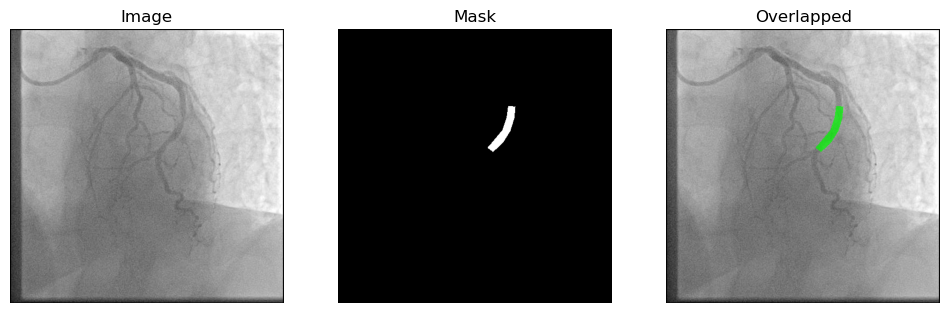

In [35]:
combined = plot_mask_and_image(augs["image"], augs["mask"])
visualize_image_and_mask(augs["image"], augs["mask"], combined)

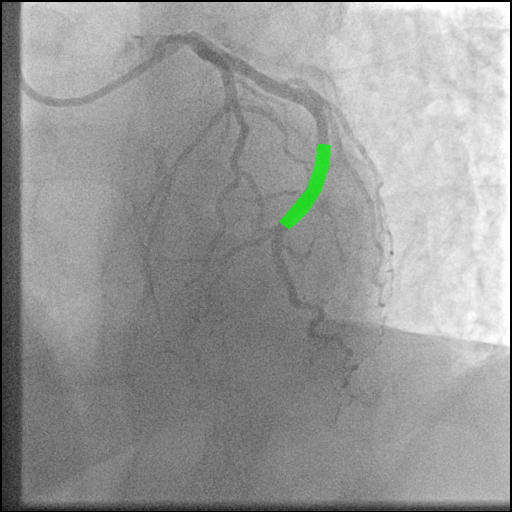

In [36]:
plot_mask_and_image(augs["image"], augs["mask"])

#### BREAK POINT ####

In [238]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.transforms import v2 as v2

In [515]:
# model loading and preprocessing
image_processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")

id2label = {0 : "Background", 1 : "Plaque"}
label2id = {"Background" : 0, "Plaque" : 1}

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=2,
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [522]:
img = Image.open("../data/processed/train/images/1.png")
msk = Image.open("../data/processed/train/masks/1.png")

img2 = Image.open("../data/processed/train/images/2.png")
msk2 = Image.open("../data/processed/train/masks/2.png")

img_com = [img, img2]
mask_com = [msk, msk2]

img_com = image_processor(img_com, msk_com, return_tensors = "pt")

len(img_com)

2

In [556]:
out = model(**img_com)

## Dataset Object Points

In [549]:
class SegmentationDataset(Dataset):
    def __init__(self, root_path, file_names, dataset_type):
        self.root_path = root_path
        self.file_names = file_names
        self.dataset_type = dataset_type
        self.image_processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")
        self.image_processor.do_reduce_labels = False
        
    def __len__(self):
        return len(file_names)
    
    def __getitem__(self, index):
        
        img_index = self.file_names[index]
        
        img_path = os.path.join(self.root_path, self.dataset_type, "images", img_index)
        msk_path = os.path.join(self.root_path, self.dataset_type, "masks",  img_index)
        
        # read the images
        img = Image.open(img_path)
        msk = Image.open(msk_path)
        
        model_inputs = self.image_processor(images = img,
                                            segmentation_maps=msk,
                                            return_tensors = "pt")
        
        return model_inputs

In [550]:
train_files = [f"{ind}.png" for ind in range(1, 998)]
test_files = [f"{ind}.png" for ind in range(1, 301)]
validation_files = [f"{ind}.png" for ind in range(1, 201)]

In [552]:
train_dataset = SegmentationDataset(root_path = "../data/processed/",
                                    file_names = train_files,
                                    dataset_type = "train")

test_dataset = SegmentationDataset(root_path = "../data/processed/",
                                   file_names = test_files,
                                   dataset_type = "test")

validation_dataset = SegmentationDataset(root_path = "../data/processed/",
                                         file_names = validation_files,
                                         dataset_type = "val")

In [553]:
model_inputs = next(iter(validation_dataset))

In [554]:
out = model(**model_inputs)

In [555]:
out.loss

tensor(0.6932, grad_fn=<NllLoss2DBackward0>)